# Steel Plate Defect Object Detection
***Authors***: RJ Green

# Summary

Modern machine learning techniques are now capable of assisting manufacturers streamline their product development in numerous ways. In this notebook, we are going to focus on detecting and classifying product defects using state of the art computer vision systems. Utilizing machine learning brings immense value to manufacturers, transforming their production processes and giving them an overall compedative edge. By leveraging these advanced methods, manufacturers can streamline product development, enhance defect detection accuracy, optimize operational efficiency, reduce costs, and ultimately deliver higher-quality products to meet the ever-growing demands of the market.

We will leverage computer vision to tackle the task of identifying product defects in hot-rolled steel plates, which are used extensively in construction and agriculture due to their superior strength and high formability. By leveraging an object detection model powered by machine learning, we can achieve precise and efficient detection and classification of one of the most prevalent product defects that steel manufactures encounter: scratches. 

In practical applications, the inspection of steel plates is performed visually by an in-factory human examiner, which is time consuming and potentially unreliable.  Our approach will stand out from traditional techniques that do not utilize machine learning, as it offers the ability to automate the detection process, enhance accuracy, and reduce human effort and error.

* download the data
* perform the neccesary data preprocessing
* split the data into training and validation datasets
* create our model
* write custom training and validation loops
* create a visualizer to evaluate model performance and take a look at the model's predictions

At the end, we will have successfully trained a highly accurate and robust machine learning model capable of detecting and classifying any sized scratch present in steel plates.

# Faster R-CNN 

First, let’s take a brief look at how Faster RCNN works. We won't dive too deep into the details - just deep enough to provide a high level understanding of how this sophisticated model works. 

If you'd like to learn more, here's a link to the original whitepaper: https://arxiv.org/pdf/1506.01497.pdf

<img src="https://lilianweng.github.io/posts/2017-12-31-object-recognition-part-3/faster-RCNN.png" alt="alt text" width="800" height="400">


First, an input image is passed through a pre-trained Convolutional Neural Network (CNN), a ResNet-50 in our case, which produces  series of feature maps. These feature maps are then passed to the Region Proposal Network (RPN) within the Faster R-CNN. The RPN slides a fixed-size anchor box across the feature maps, which serves as a reference template. To accommodate objects of various shapes, different anchor boxes with different scales and aspect ratios are passed over each feature map. For each anchor box, the RPN generates an "objectness score" to determine if there is an object present within the box, as well as a "bounding box regression score" that represents the accuracy of the coordinates	of the bounding box that most tightly encompasses the object. The boxes are subsequently filtered based on their objectness score, typically by selecting the top-n proposals as the region proposals.

Next, the region proposals are used to extract fixed-sized feature vectors from the feature maps through a process called "region of interest pooling". This way regions of different size can be converted to the same size and fed into subsequent layers without issue. The extracted feature vectors are fed into two distinct fully-connected layers: the Classification and Regression heads. These layers perform further analysis and interpretation of the features to classify objects and refine their bounding box coordinates, respectively.

Once trained, our Faster R-CNN will be able to take in an image of a steel plate, locate and classify any scratches it finds, and return the image with rectangular bounding boxes placed around the detected scratches (if there are any).

# Setup

Now that we have a general understanding of how the model works, lets begin by installing the necessary packages and importing the libraries we will need to train our model.

In [ ]:
%pip install -q -r training/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import glob as glob
import os
from pathlib import Path
import random
import urllib.request
import zipfile

from IPython.display import display
from PIL import Image
import cv2
import numpy as np
import torch
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Next, let's load our data. We will be using the **NEU Steel Surface Defects Database** from North Eastern University, available for free on Kaggle. It contains 1,800 image and annotation pairs in total, which are divided into two datasets, one for training and one for validation. The training dataset contains 80% of the data, and the validation dataset contains the remaining 20%. It's good practice to keep roughly 20% of your data seperate for validating your model. This is critical to guard against overfitting and ensure the model generalizes well. 

The data contains annotations for 6 different types of common steel plate production defects, but to keep things simple, we will only train our model to detect scratches for this project. 

More details of the dataset can be found on the [NEU Surface Defect Database kaggle page](https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database).

The following code downloads the dataset, unzips it, and removes unneeded extra files leftover from the unzipping proccess.

In [9]:
urllib.request.urlretrieve(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/NEU-DET/NEUSurfaceDefectDatabase.zip",
    "./NEU-DET.zip",
)
with zipfile.ZipFile("./NEU-DET.zip", "r") as zip_ref:
    zip_ref.extractall("./")

os.listdir("./NEU-DET/")

['train', 'validation']

In [ ]:
!rm -rf storage/NEU-DET.zip
!rm -rf storage/__MACOSX

Let's also rename it from '**/NEU-DET**' to '**/notebook_data**' for clarity.

In [ ]:
os.rename("/home/notebooks/storage/NEU-DET", "/home/notebooks/storage/notebook_data")

As is so often the case, our data contains mistakes and is not formatted in a way that is easy for our model to train with. Let's do some data preprocessing to fix these mistakes and get our data organized neatly. 

In particular, we will need to:
1. Move all of the training and validation images out of their sub-directories (i.e. '/scratches') into '**/images**' to match the structure of '**/annotations**'
2. Remove any unwanted files or directories that will create problems during the training process
3. Move a missplaced validation image into its correct directory

First up, let's reorganize the image directory structure. We can hand the filepaths for our training and validation directories to our `organize_data()` function to make these changes.

In [ ]:
def organize_data(data_dir):
    for directory in os.listdir(os.path.join(data_dir, "images")):
        sub_dirs = os.path.join(data_dir, "images", directory)
        if not os.path.isdir(sub_dirs):
            continue
        for file in os.listdir(sub_dirs):
            os.rename(
                os.path.join(sub_dirs, file),
                os.path.join(data_dir, "images", file),
            )
        os.rmdir(sub_dirs)


organize_data("storage/notebook_data/train")
organize_data("storage/notebook_data/validation")

Next, let's remove any unwanted directories or files and move the incorrectly placed validation image. Afterwards, we will do a quick check to make sure that we didn't accidentally delete any images or annotations.

In [ ]:
def remove_unwanted_files_and_dirs(data_dir):
    for dir in os.listdir(data_dir):
        if dir == ".DS_Store":
            os.remove(os.path.join(data_dir, dir))


def clean_data():
    os.rename(
        "/home/notebooks/storage/notebook_data/train/images/crazing_240.jpg",
        "/home/notebooks/storage/notebook_data/validation/images/crazing_240.jpg",
    )


remove_unwanted_files_and_dirs("storage/notebook_data/")
remove_unwanted_files_and_dirs("storage/notebook_data/train")
remove_unwanted_files_and_dirs("storage/notebook_data/train/images")
remove_unwanted_files_and_dirs("storage/notebook_data/validation")
clean_data()

In [ ]:
num_train_images = len(list(Path("storage/notebook_data/train/images/").glob("*.jpg")))
num_val_images = len(list(Path("storage/notebook_data/validation/images/").glob("*.jpg")))
num_train_annotations = len(list(Path("storage/notebook_data/train/annotations/").glob("*.xml")))
num_val_annotations = len(list(Path("storage/notebook_data/validation/annotations/").glob("*.xml")))

print(f"Number of Training Images: {num_train_images}")
print(f"Number of Training Annotations: {num_train_annotations}")
print(f"Number of Validation Images: {num_val_images}")
print(f"Number of Validation Annotations: {num_val_annotations}")
print(f"Total Number of Images: {num_train_images + num_val_images}")

Number of Training Images: 1439
Number of Training Annotations: 1439
Number of Validation Images: 361
Number of Validation Annotations: 361
Total Number of Images: 1800


Now that our data has be cleaned and reorganized, we can begin to build our datasets. Namely, we want to seperate the data into training and validation datasets, pair each image with its associated annotation bounding boxes, and make each pair easily iterable for the model. We will use the Pytorch **Dataset** class, as well as a few custom written classes to accomplish this. Let's import the neccessary custom classes.

In [ ]:
from src.data.annotation import Annotation
from src.data.bbox import Bbox
from src.data.dataset_builder import DatasetBuilder
from src.data.dataset_builder_config import DatasetBuilderConfig
from src.data.image_dataset import ImageDataset

We wont completely flesh out all these classes here in the notebook, but if you'd like to take a look at the code just check '**/src/data**'. 

* The `Annotation` class is responsible for holding each image and it's labeled bounding boxes, as well as converting the image and the bounding box data into tensors our model can interpret

* The `Bbox` class is responsible for holding the bounding box coordinate values, as well as the class labels per image defect type (1 for scratch, 0 for no scratch)

* The `ImageDataset` class is responsible for holding a list of `Annotation` class instances, which in turn are iterable

* The `DatasetBuilderConfig` holds XML tag values that we will use to parse the annotation files and collect bounding box information

* The `DatasetBuilder` is responsible for parsing the annotation XML files, pairing them with their associated image, and creating the annotations. These annotations are then used to create our *train_dataset* and *val_dataset* objects, which are both instances of the `ImageDataset` class.

This small chunk of code is all we need to build our datasets. We simply pass in the filepaths for our training and validation directories, an instance of the `DatasetBuilderConfig` class, and call `build_datasets()`.

```python
train_dataset, val_dataset = DatasetBuilder(
    train_data_dir="notebook_data/train",
    val_data_dir="notebook_data/validation",
    config=DatasetBuilderConfig(),
).build_datasets()
```

Now that we have clean, easily iterable train and validation datasets, we can move on to creating our model. We are going to used a pre-trained **Faster R-CNN** availble for free from PyTorch. 

We are going impliment a technique known as "fine-tuning", where we will further train the pre-trained model with custom data to improve its performance on a specific task - in our case, detecting scratches in steel plates. Fine-tuning a pre-trained model is a very popular approach becuase it allows us to leverage existing knowledge within the model, reduce training time, and achieve excellent performance with limited data.

Let's create a `Model` class that will allow us to load a **Faster R-CNN** pre-trained from PyTorch, but also give us the option to load a model that we have already trained. This will be useful later on when we want to evaluate our model's performance and make predictions.

In [ ]:
class Model:
    @classmethod
    def get_model(cls):
        model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
        return model

    @classmethod
    def get_model_from_checkpoint(cls, checkpoint_path):
        model = cls.get_model()
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device("cpu")))
        return model

Next up, we can import all the neccessary classes to create our training and validation loops, which are responsible for training our model, evaluating its performance, and saving the model's weights. 

Much like our dataset builder logic, we won't be able to fit all of the code into this notebook, but we will go over the important parts. If you'd like to take a look at the code, check out '**/src/training**'.

In [ ]:
from src.training.trainer import Trainer
from src.training.training_config import TrainingConfig
from src.utils.stats_aggregator import StatsAggregator

* The `TrainerConfig` class holds all the hyperparameters we will use to train our model, as well as the filepaths for our training and validation datasets. These can be easily adjusted during experimentation.

* The `StatsAggregator` class keeps track of our model's training and validation loss throughout each epoch, as well as the number of epochs it has been trained for. It also contains a few print methods that will be useful for displaying our model's performance.

* The `Trainer` class is responsible for the actual training of our model, as well as continually evaluating it's proficiency and saving the model when it achieves impressive performance. It also produces "loss_plots" that track training and validation loss over each epoch.

Below are the training and validation loops. As you can see, they are almost identical.

In each loop, we iterate over the images and annotations in the specified dataset and send them to the model. The model makes predictions on the images and returns a dictionary of loss values based on the difference between the predicted bounding boxes and the ground truth bounding boxes, as well as the difference between the predicted class labels and the ground truth class labels.

The main difference between the two loops is what we do with the returned loss values. In the training loop, we use the loss values to calculate the gradients of the model's parameters, which we then use to update the model's weights via backpropgation. In the validation loop, we simply keep track of the loss values for each image and annotation pair to evaluate the model's performance, and do not allow the model to "learn" (update its weights).



```python
def train_epoch(self):
    self.model.train()

    loop = tqdm(self.train_dataloader, total=len(self.train_dataloader))
    for images, targets in loop:
        self.optimizer.zero_grad()
        images = [image.to(self.device) for image in images]
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

        loss_dict = self.model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        self.train_loss_epoch_stats.send(loss_value)

        losses.backward()
        self.optimizer.step()

        loop.set_postfix(running_train_loss=f"{loss_value:.4f}")

def validate_epoch(self):
    loop = tqdm(self.val_dataloader, total=len(self.val_dataloader))
    for images, targets in loop:
        images = [image.to(self.device) for image in images]
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = self.model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        self.val_loss_epoch_stats.send(loss_value)

        loop.set_postfix(running_val_loss=f"{loss_value:.4f}")
```

Now we need to define a `collate_fn()` function, which helps with organizing and preparing the data in a batched format for object detection tasks, making it easier to process the data efficiently during training or inference. This fucntion will be passed as an argument to our dataloaders.

In [ ]:
def collate_fn(batch):
    return [b[0] for b in batch], [b[1] for b in batch]

Finally, we can create our `TrainingSession` class, which is responsible for training setup and configuration. This is where we will actually create datasets and dataloaders, instantiate our model, configure our optimizer, and tell our `Trainer` to begin training.

To initialize our `TrainingSession` class, we only need to pass in a `TrainingConfig` object, which holds all the hyperparameters we will use to train our model, and a `DatasetBuilderConfig` object to hold our data parsing information. All we need to do next is call the `run()` method, and our model will begin training!

In [ ]:
class TrainingSession:
    """TrainingSession is responsible for model training setup and configuration."""

    def __init__(self, training_config, dataset_builder_config):
        self.training_config = training_config
        self.dataset_builder_config = dataset_builder_config

    def run(self):
        self.create_datasets()
        self.create_dataloaders()
        self.create_model()
        self.configure_device()
        self.create_optimizer()
        self.create_trainer()
        self.trainer.run()

    def create_datasets(self):
        dataset_builder = DatasetBuilder(
            self.training_config.train_data_dir,
            self.training_config.val_data_dir,
            self.dataset_builder_config,
        )
        self.train_dataset, self.val_dataset = dataset_builder.build_datasets()

    def create_dataloaders(self):
        self.train_dataloader = DataLoader(
            self.train_dataset,
            batch_size=self.training_config.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
        )
        self.val_dataloader = DataLoader(
            self.val_dataset,
            batch_size=self.training_config.batch_size,
            collate_fn=collate_fn,
        )

    def create_model(self):
        self.model = Model.get_model()

    def configure_device(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def create_optimizer(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = SGD(
            params=params,
            lr=self.training_config.learning_rate,
            momentum=self.training_config.momentum,
            weight_decay=self.training_config.weight_decay,
        )

    def create_trainer(self):
        self.trainer = Trainer(
            model=self.model,
            train_dataloader=self.train_dataloader,
            val_dataloader=self.val_dataloader,
            optimizer=self.optimizer,
            device=self.device,
            config=self.training_config,
        )

Depending upon how many epochs you choose to train for, the training process could take anywhere from 10 minutes to an hour. Once training is complete, the `Trainer` will have seaved multitple versions the model's weights, each corresponding to a different high performing epoch. You will also receive a message that tells you which epoch your model achieved the lowest validation loss, and the loss value itself. This is the model we will use to make predictions on our validation images.

In [ ]:
training_config = TrainingConfig()
dataset_builder_config = DatasetBuilderConfig()
session = TrainingSession(training_config, dataset_builder_config)
session.run()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/notebooks/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 214MB/s]
Epoch 1 of 5
  0%|          | 0/9 [00:00<?, ?it/s]

Now that we have a fine-tuned model, lets use it to make some predictions on our validation images and see how it performs! 

To do this, we will need to get the filepath to our model's saved weights, which we can find in the '**/model_ckpts**' directory. We will also need to create a `Visualizer` class, which will be responsible for loading our model's weights, making predictions on our validation images, and displaying the images with their predicted bounding boxes.

In [ ]:
class Visualizer:
    def __init__(self, model_ckpt):
        self.model_ckpt = model_ckpt

    def show_image(self, image_filepath):
        image = cv2.imread(image_filepath)
        tensor_image, orig_image = self._convert_image_to_tensor(image)
        self._load_model()
        outputs = self._run_model_inference(tensor_image)
        draw_boxes = self._get_boxes(outputs)
        self._display_image(orig_image, draw_boxes)

    def _convert_image_to_tensor(self, image=None):
        orig_image = image.copy()
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1)).astype(float)
        tensor_image = torch.tensor(image, dtype=torch.float)
        return tensor_image, orig_image

    def _load_model(self):
        self.model = Model.get_model_from_checkpoint(checkpoint_path=self.model_ckpt)
        self.model.eval()

    def _run_model_inference(self, tensor_image=None):
        tensor_image = torch.unsqueeze(tensor_image, 0)
        with torch.no_grad():
            outputs = self.model(tensor_image)
        outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]
        return outputs

    def _get_boxes(self, outputs, detection_threshold=0.80):
        boxes = outputs[0]["boxes"].data.numpy()
        scores = outputs[0]["scores"].data.numpy()
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        return draw_boxes

    def _display_image(self, orig_image, draw_boxes):
        for _j, box in enumerate(draw_boxes):
            cv2.rectangle(
                orig_image,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                (0, 0, 255),
                1,
            )
        display(Image.fromarray(orig_image))

To initialize our `Visualizer` class, we only need to pass in the filepath to our model's saved weights. When picking which saved model to use, it is best to choose the one with the lowest validation loss, as this is the model that was able to generalize the best. This saved model will be located in the '**/model_ckpts**' directory, and the `Trainer` will have printed out which epoch it corresponds to at the end of training.

In [ ]:
visualizer = Visualizer(model_ckpt="/home/notebooks/storage/model_state_dict.pth")

Finally, we'll choose an image we would like to predict on and pass it's filepath to the `show_image()` method. This method will display the image with the model's predicted bounding boxes overlaid on top of it.

For the purposes of this demo, we will choose 3 random "scratch" images and 3 random "no scratch" images from our validation dataset to make predictions on. Feel free to change the filepaths of the images to see how the model performs on different images.

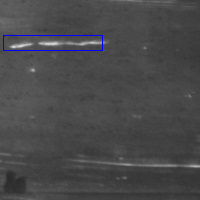

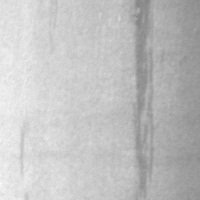

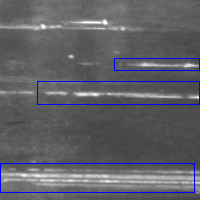

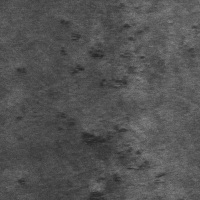

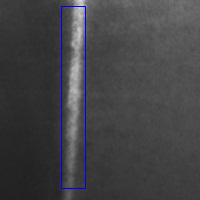

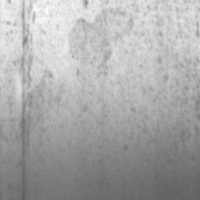

In [ ]:
visualizer.show_image(image_filepath="storage/notebook_data/validation/images/scratches_242.jpg")
visualizer.show_image(image_filepath="storage/notebook_data/validation/images/inclusion_248.jpg")
visualizer.show_image(image_filepath="storage/notebook_data/validation/images/scratches_275.jpg")
visualizer.show_image(
    image_filepath="storage/notebook_data/validation/images/rolled-in_scale_280.jpg"
)
visualizer.show_image(image_filepath="storage/notebook_data/validation/images/scratches_288.jpg")
visualizer.show_image(
    image_filepath="storage/notebook_data/validation/images/pitted_surface_281.jpg"
)

And there we go! Our model has been fine-tuned and is capable of detecting scratches in steel plates with impressive accuracy. We can see that the model is able to detect scratches of all shapes and sizes, and is even able to distinguish between scratches and other markings on steel plates, such as inclusions or pitted surfaces.

We hope you enjoyed this demo and learned something new about machine learning and object detection! The uses for object detection are endless, and could be an invaluable tool for any manufacturing or retail business that needs to detect and classify any type of product defect.